In [ ]:
# inspired by https://arxiv.org/pdf/1907.02704.pdf and thu vu data analysis
# 

In [1]:
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from selenium import webdriver
from webdriver_manager.firefox import GeckoDriverManager

from selenium.webdriver.firefox.options import Options #to tweak options
from selenium.common.exceptions import NoSuchElementException #to raise error
from selenium.webdriver.common.by import By #to use find_element

import unidecode
import networkx as nx

print('package loaded')

package loaded


## Load Web Page 

In [2]:
# to disable GUI
firefox_options = Options()
firefox_profile = webdriver.FirefoxProfile()

firefox_options.add_argument("--headless") # Ensure GUI is off
#firefox_options.add_argument("--no-sandbox") # if i understand well, make it faster but less safe

# to disable image loading
firefox_profile = webdriver.FirefoxProfile()
firefox_profile.set_preference('permissions.default.image', 2)
firefox_profile.set_preference('dom.ipc.plugins.enabled.libflashplayer.so', 'false')

# to load the web browser
driver = webdriver.Firefox(executable_path=GeckoDriverManager().install(), options=firefox_options, firefox_profile=firefox_profile)
print('web loaded')

[WDM] - Downloading: 19.0kB [00:00, 6.50MB/s]                                                                          
[WDM] - Downloading: 100%|████████████████████████████████████████████████████████| 1.58M/1.58M [00:00<00:00, 2.33MB/s]


web loaded


In [26]:
# to quit the driver
driver.quit()
print('driver quited')

driver quited


In [8]:
choices = ["https://lotr.fandom.com/wiki/Category:The_Hobbit_Characters", 
           'https://lotr.fandom.com/wiki/Category:Characters_in_The_Children_of_H%C3%BArin', 
           'https://lotr.fandom.com/wiki/Category:The_Silmarillion_characters', 
          'https://tolkiengateway.net/wiki/Category:Characters_in_The_Hobbit']

page_url = choices[3]
driver.get(page_url)

# Accept cookies
#time.sleep(3)
try:
    driver.find_element(By.XPATH, '//div[text()="ACCEPTER"]').click()
except NoSuchElementException:
    print('no cookie button, or not in french')

no cookie button, or not in french


## Data mining lotr.fandom

In [ ]:
# Find the different characters in the hobbit with the first website
characters_listed_ref = driver.find_elements(by=By.CLASS_NAME, value="category-page__member-link")
characters_listed = [(i.text, i.get_attribute('href')) for i in characters_listed_ref]

In [ ]:
person_dict = {}
characters_list = []
iterator = 0
for person in characters_listed:
    person_dict = {} #assign to {} to change the pointer
    person_features = ["race", "gender"]
    person_url = person[1]
    person_name = person[0]

    person_dict['names'] = person_name
    person_dict['link'] = person_url
    # goes to the character webpage to mine the data
    driver.get(person_url)
    
    # find the element of wikipedia
    for feature in person_features:
        try:
            #get the div with data-source Race
            text = driver.find_element(By.XPATH, '//div[@data-source =\"' + feature + '"]/descendant::div').text 
            if feature == "othernames":
                person_dict['names'] += ", " + text
            else:
                person_dict[feature] = text
        except NoSuchElementException:
            person_dict[feature] = 'NaN'
            
    if not('Category' in person_dict['names']):
        characters_list.append(person_dict)
        
    progress = int(iterator/len(characters_listed) * 100)
    print(progress, " % progress")
    iterator += 1
characters_df = pd.DataFrame(characters_list)
print("100 % progress")

## Data mining tolkien gateway

In [9]:
characters_listed_ref = driver.find_elements(By.CSS_SELECTOR, 'div.mw-category-group > ul > li > a')
characters_listed = [(i.text, i.get_attribute('href')) for i in characters_listed_ref]

In [ ]:
person_dict = {}
characters_list = []
iterator = 0
for person in characters_listed:
    person_dict = {} #assign to {} to change the pointer
    
    person_url = person[1]
    person_name = person[0]

    person_dict['names'] = person_name
    person_dict['link'] = person_url
    
    # goes to the character webpage to mine the data
    driver.get(person_url)
    
    # get the race of the person
    try:
        person_dict['race'] = driver.find_element(By.CSS_SELECTOR, "tr:nth-child(2) > td > a").text
    except NoSuchElementException:
        person_dict['race'] = 'NaN'    
    
    # 
    person_add_features = ["gender"]
    
    for feature in person_add_features:
        try:
            #get the right td, using the td before that contains feature's name
            text = driver.find_element(By.XPATH, "//td[contains(.,'" + feature.capitalize() + "')]/following-sibling::td").text
            person_dict[feature] = text
            
        except NoSuchElementException:
            person_dict[feature] = 'NaN'  

    if not('Category' in person_dict['names']):
        characters_list.append(person_dict)
        
    progress = int(iterator/len(characters_listed) * 100)
    print(progress, " % progress")
    iterator += 1
characters_df = pd.DataFrame(characters_list)
characters_df.to_json("data/mining/characters_hobbit.json")
print("100 % progress")

In [ ]:
characters_df.head(100)


## Data viz from data mining

In [59]:
characters_df = pd.read_csv('data/mining/Silmarillion.csv')
characters_df['race'] = characters_df['race'].apply(lambda x : 'Half-elves' if 'Half-elves' in str(x) else x)
characters_df['race'] = characters_df['race'].apply(lambda x : 'Ainur' if 'Ainur' in str(x) else x)


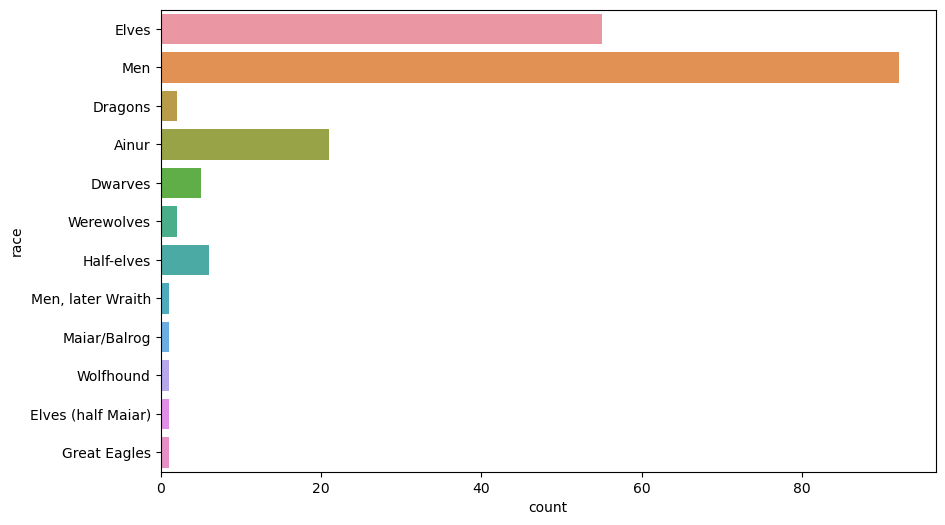

In [60]:
plt.figure(figsize=(10,6))
sns.countplot(y = characters_df['race'] )
plt.show()


In [ ]:
characters_df.loc[characters_df['race'] == 'Men' & characters_df['gender'] == 'Female']

## Book analysis

### Setup

#### Modify the characters_df to fit the text analysis

In [5]:
characters_df = pd.read_json("data/mining/characters_hobbit.json")

# modify the data to fit best the book analysis

def characters_df_modification(x, to_change = [], change_into = [], exception = [], contain = []):
    # to_change, change_into is to set names that are to be replaced
    # exception is names that DO NOT have to be changed
    # contain is First part of a word that has to be replaced
    if contain == []:
        contain.append([""]) # trick to make following lines relevant if contain is empty
    if x in exception:
        return x
    word_split = x.split(" ", 1)
    if len(word_split)>1:
        for word_contain in contain:
            if word_contain in word_split:
                print(word_contain)
                x = word_split[1]
                print(x)
            else:
                x = word_split[0]
        if x in to_change:
            x = change_into[to_change.index(x)]
    return unidecode.unidecode(x)

to_change = ["Eagle"]
change_into = ["Eagles"]
contain = ["Great"]

characters_df['names'] = characters_df['names'].apply(lambda x: characters_df_modification(x, to_change, change_into, contain = contain))

Great
Eagle
Great
Goblin


#### Set the relationships to default

In [6]:
relationships = []
relationship_dict = {}

for source in characters_df['names']:
    for target in characters_df['names']:
        if source == target:
            continue
        relationship_dict = {}
        relationship_dict['source'] = source
        relationship_dict['target'] = target
        relationship_dict['value'] = 0
        relationships.append(relationship_dict)
relationships_df = pd.DataFrame(relationships)
relationships_df.to_json("data/relations/relationships_hobbit_zero.json")

#### Get book's content and seperate it in chapters

In [2]:
chapters = []
new_chapter = ""
books = ["hobbit.txt", "lotr_1.txt"]
path_books = "data/books/"
with open(path + books[1]) as file:
    for line in file:
        line_corrected = line.rstrip()
        if "Chapter" in line_corrected and len(line_corrected) < 20:
            # seperates book in chapters, and removes the line "Chapter XX"
            if new_chapter != "":
                chapters.append(new_chapter)
            new_chapter = ""
            continue
        if len(line_corrected)>1:
            new_chapter += line_corrected + "\n"

### Analysis

#### Compute the interactions between characters

In [54]:
relationships_df = pd.read_json("data/relations/relationships_hobbit_zero.json")

def relation_attribution(scene, relation_df, characters):
    # if 2+ characters are in the same text interval, they get one interaction
    # the "source" and "target" is necessary for the graph
    character_in_scene = []
    for character in characters:
        if character in scene and character not in character_in_scene:
            character_in_scene.append(character)
    for source in character_in_scene:
        for target in character_in_scene:
            relation_df.loc[(relation_df['source'] == source) & (relation_df['target'] == target), "value"] += 1

for chapter_progress in chapters:
    scene_length = 2000
    prev_iteration = 0
    chapter_length = len(chapter_progress)

    for iteration in range(scene_length, chapter_length, scene_length):
        # attributes the interactions between characters 
        scene = chapter_progress[prev_iteration:iteration]
        relation_attribution(scene, relationships_df, characters_df.names) 
        # if the next text interval is not long enough to be > scene_length, expand it 
        if chapter_length < iteration + scene_length:
            scene += chapter_progress[iteration:]
        prev_iteration = iteration
relationships_df = relationships_df.loc[(relationships_df['value'] > 0)]
relationships_df.to_json("data/relations/relationships_hobbit.json")

#### Setup of the network graph

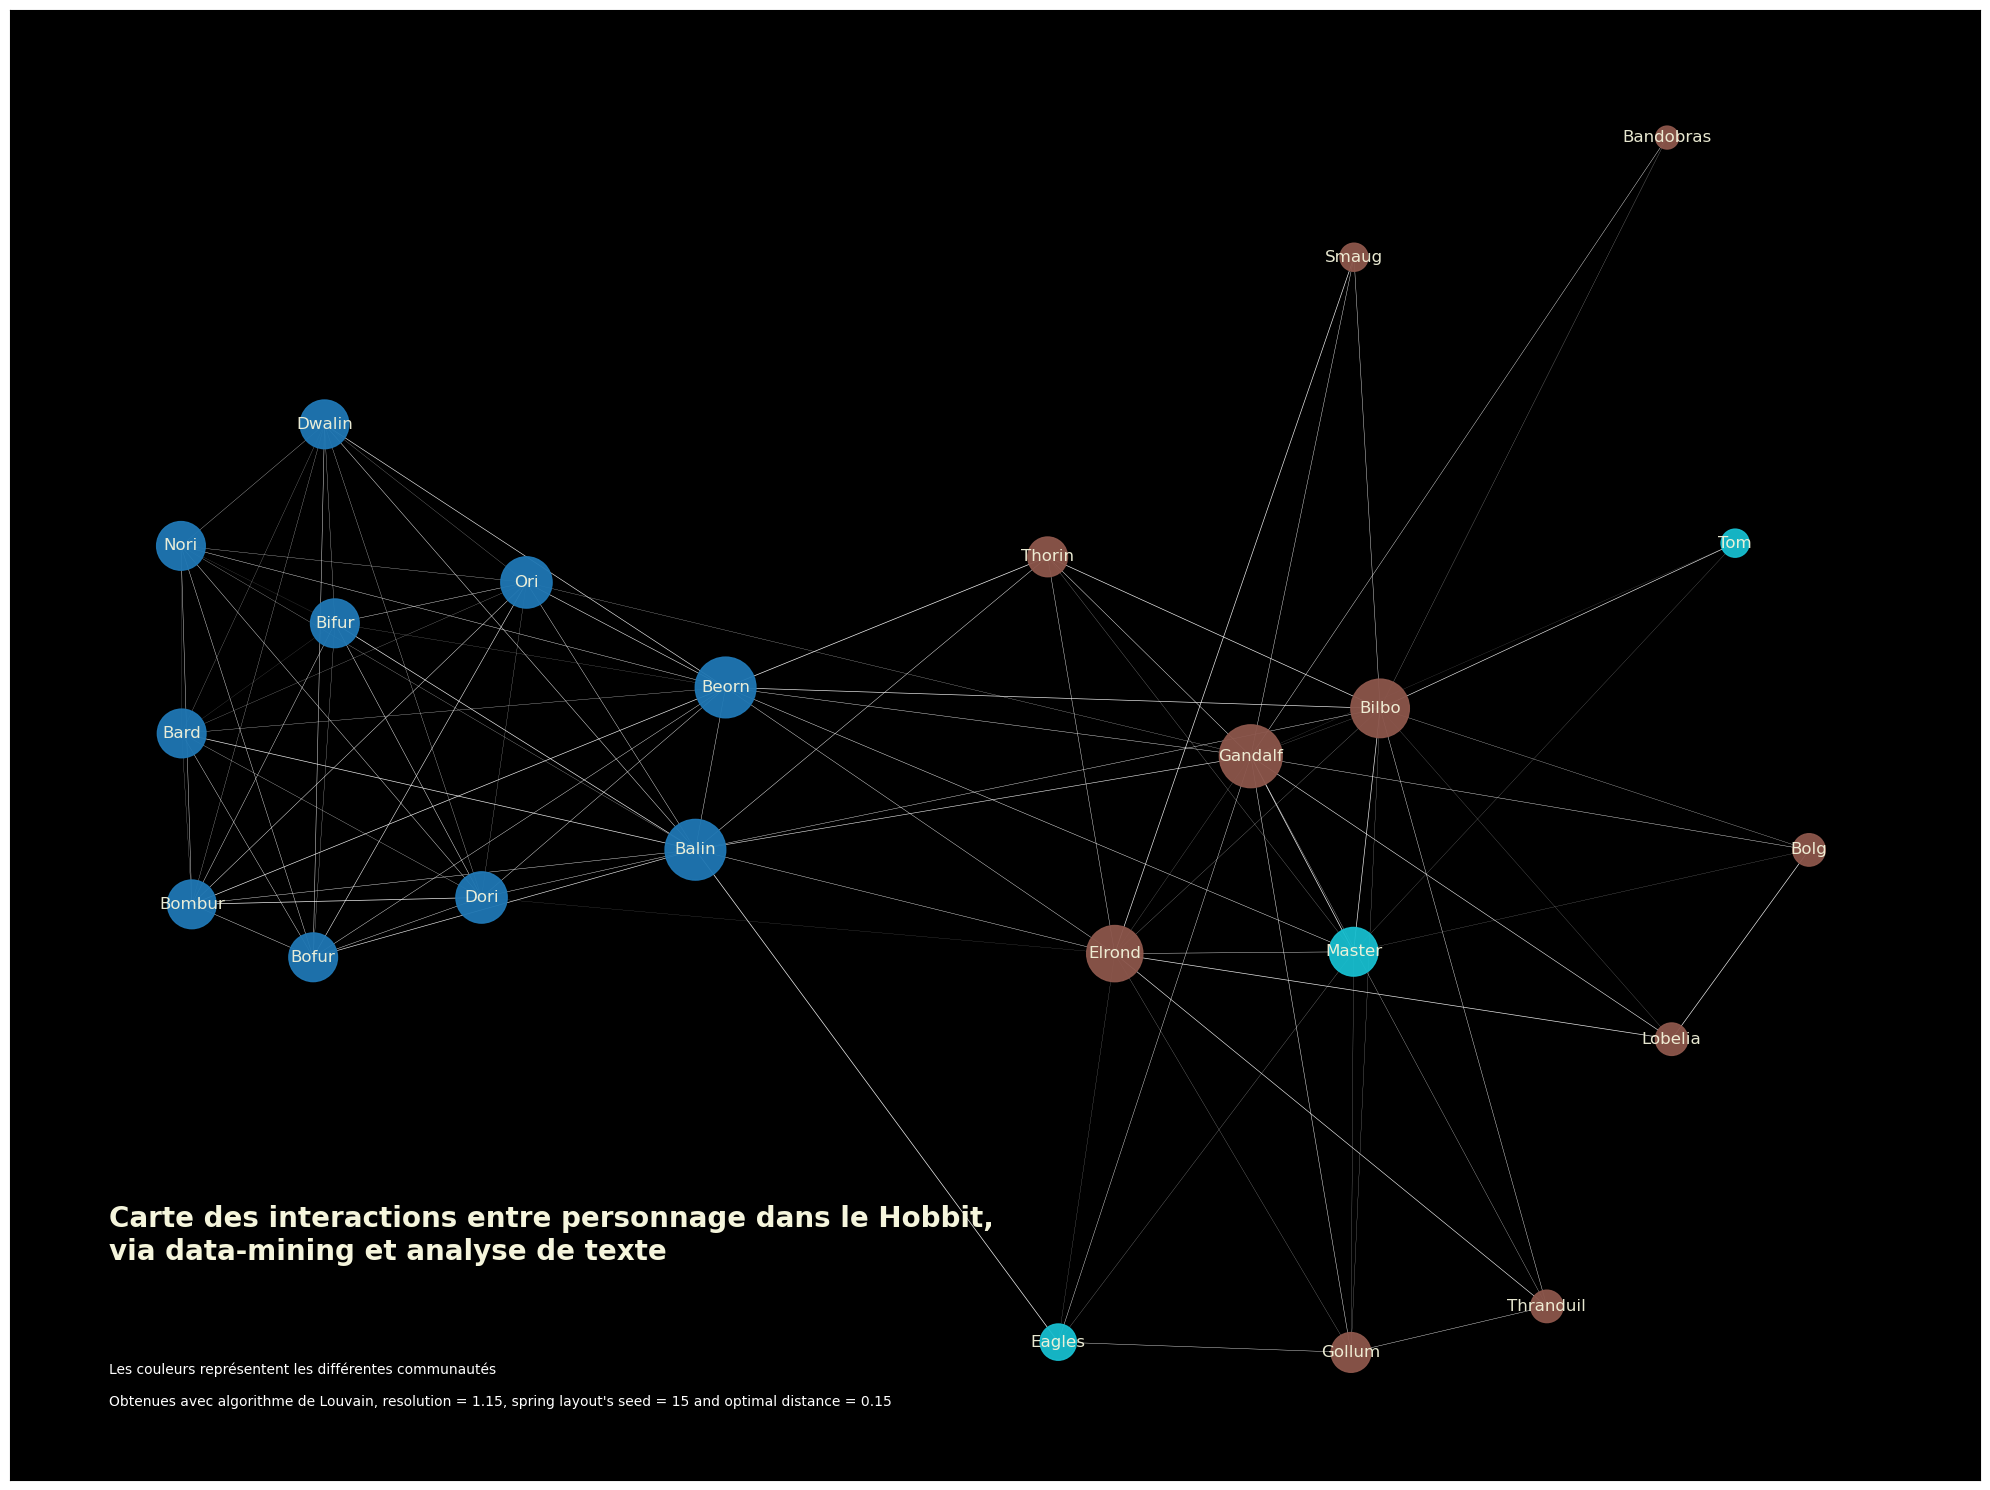

In [55]:
##### Create a graph from a pandas dataframe
from random import choices

G = nx.from_pandas_edgelist(relationships_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value",
                            create_using = nx.Graph())

# largest connected component
components = nx.connected_components(G)
largest_component = max(components, key=len)
H = G.subgraph(largest_component)

# compute centrality
#centrality = nx.betweenness_centrality(H, k=10, endpoints=True)
centrality = nx.degree_centrality(H)
#centrality = nx.closeness_centrality(H)

# compute community structure
lpc = nx.algorithms.community.louvain_communities(G, weight='value', resolution=1.10, threshold=1e-07, seed=1)
community_index = {n: i for i, com in enumerate(lpc) for n in com}


#### draw graph ####
degree_dict = dict(G.degree)
fig, ax = plt.subplots(figsize=(20, 15))
ax.set_facecolor("black")
pos = nx.spring_layout(H, k=0.15, seed=4572321)
# first seed = 4572321

max(community_index.values())
node_color = [community_index[n] for n in H]
node_size = [v * 3000 for v in centrality.values()]
linewidths = [v/(max(degree_dict.values()) * 2) for v in degree_dict.values()]
linecolor = [community_index[n] for n in H]

nx.draw_networkx(
    H,
    pos=pos,
    with_labels=True,
    node_color=node_color,
    node_size=node_size,
    width = linewidths,
    alpha = 0.95,
    cmap = "tab10",
    font_color = "beige",
    edge_color= "white",
    edge_cmap = "tab10"
)
# Title/legend
# Change font color for legend

ax.text(
    0.05,
    0.05,
    "Les couleurs représentent les différentes communautés\n\nObtenues avec algorithme de Louvain, resolution = 1.15, spring layout's seed = 15 and optimal distance = 0.15",
    horizontalalignment="left",
    transform=ax.transAxes,
    color = "white",
    fontweight = "light", 
    fontsize = 10,
)

ax.text(
    0.05,
    0.15,
    "Carte des interactions entre personnage dans le Hobbit,\nvia data-mining et analyse de texte",
    horizontalalignment="left",
    transform=ax.transAxes,
    color = "beige",
    fontweight = "bold", 
    fontsize = 20,
)
fig.tight_layout()
plt.savefig("img/network2.png")


In [35]:
list(nx.bridges(G))

[('Gandalf', 'Bandobras'), ('Bard', 'Beorn')]

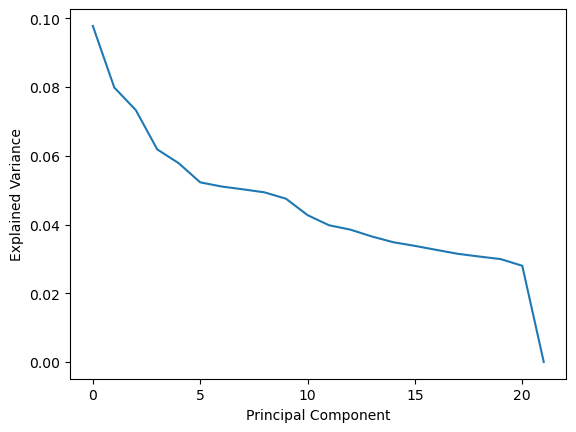

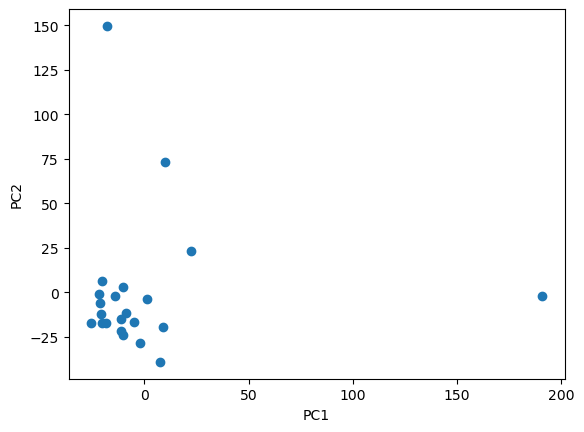

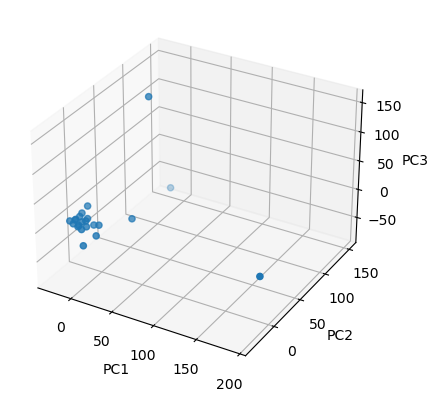

In [4]:
#python3
#use PCA to analyse a novel like the hobbit

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#load the data
data = chapters[::]

#create a dictionary of words
words = {}
for line in data:
    for word in line.split():
        if word in words:
            words[word] += 1
        else:
            words[word] = 1

#create a list of words
word_list = []
for word in words:
    word_list.append(word)

#create a matrix of word counts
word_counts = np.zeros((len(data), len(word_list)))
for i in range(len(data)):
    for j in range(len(word_list)):
        word_counts[i,j] = data[i].count(word_list[j])

#standardize the data
scaler = StandardScaler()
scaler.fit(word_counts)
word_counts_std = scaler.transform(word_counts)

#perform PCA
pca = PCA()
pca.fit(word_counts_std)

#plot the explained variance
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

#plot the first two principal components
pca = PCA(n_components=2)
pca.fit(word_counts_std)
word_counts_pca = pca.transform(word_counts_std)
plt.scatter(word_counts_pca[:,0], word_counts_pca[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#plot the first three principal components
pca = PCA(n_components=3)
pca.fit(word_counts_std)
word_counts_pca = pca.transform(word_counts_std)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(word_counts_pca[:,0], word_counts_pca[:,1], word_counts_pca[:,2])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

In [5]:

import re

def get_matching_words(regex):
  words = ["aimlessness", "assassin", "baby", "beekeeper", "belladonna", "cannonball", "crybaby", "denver", "embraceable", "facetious", "flashbulb", "gaslight", "hobgoblin", "iconoclast", "issue", "kebab", "kilo", "laundered", "mattress", "millennia", "natural"]
  return [word for word in words if re.search(regex, word)]

print(get_matching_words("v"))
print(get_matching_words("ss"))
print(get_matching_words("e$"))
print(get_matching_words("b.b"))
print(get_matching_words("b.+b"))
print(get_matching_words("b.*b"))
print(get_matching_words("a.e.*i.*o.*u"))
print(get_matching_words("^[regularexpression]+$"))

['denver']
['aimlessness', 'assassin', 'issue', 'mattress']
['embraceable', 'issue']
['baby', 'crybaby', 'kebab']
['baby', 'crybaby', 'embraceable', 'flashbulb', 'hobgoblin', 'kebab']
['baby', 'crybaby', 'embraceable', 'flashbulb', 'hobgoblin', 'kebab']
['facetious']
['assassin', 'issue']
